Fit to recent data: a = 0.3594554761515415 , b = 0.13248706303377802, c = -13.809234291705227
Fit to all data: a = 0.22729395092352844 , b = 0.14122023673193684, c = -6.929240517756776
R2: 0.9923883700150683
R2: 0.9916405855128271
Today: 359
+One week: 929
+Two weeks: 2369


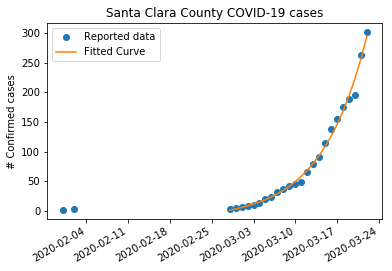

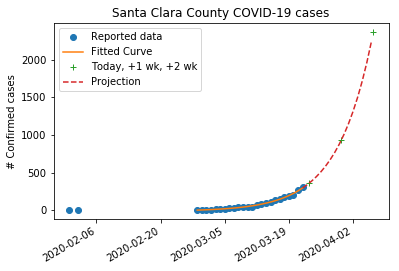

In [2]:
%matplotlib inline

# Analysis of COVID-19 case data for Santa Clara County, CA
# Chad R. Frost
# chad@chadfrost.com
# (c) 2020

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

# Exponential growth model
def func(x, a, b, c):
    return a * np.exp(b * x) + c

# R2 assessment of fit to data
def r2(x, y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)

    return r2

# Utililty conversion from datetime to numeric list (used to plot) and array referenced to a common date (used to fit)
def dates2fit(dates, refdate): # where dates = list of desired dates, as datetime; refdate = starting date
    refdate = mdates.date2num(refdate)
    numdates = mdates.date2num(dates)
    fitdates = np.array(numdates, dtype=float)
    fitdates = fitdates - refdate
    return(numdates, fitdates)

# Data from https://www.sccgov.org/sites/phd/DiseaseInformation/novel-coronavirus/Pages/known-cases-of-coronavirus.aspx
# and https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_California#Daily_Case_Data_for_Santa_Clara_County
# and (most recently) https://www.dropbox.com/h?preview=scccoronavirus.xlsx
dates = ['01/31/2020', 
         '02/02/2020', 
         '02/28/2020', 
         '02/29/2020', 
         '03/01/2020', 
         '03/02/2020', 
         '03/03/2020', 
         '03/04/2020', 
         '03/05/2020', 
         '03/06/2020', 
         '03/07/2020',
         '03/08/2020',
         '03/09/2020',
         '03/10/2020',
         '03/11/2020',
         '03/12/2020',
         '03/13/2020',
         '03/14/2020',
         '03/15/2020',
         '03/16/2020',
         '03/17/2020',
         '03/18/2020',
         '03/19/2020',
         '03/20/2020',
         '03/21/2020',
         '03/22/2020'
        ]
cases = [1, 1, 1, 1, 2, 2, 2, 3, 6, 4, 8, 5, 6, 3, 3, 18, 13, 12, 23, 24, 17, 20, 14, 7, 67, 39]


# Create a running total from daily cases
total = []
for i in range(1,len(cases)+1):
    total.append(sum(cases[0:i]))

# Build a list of datetime objects from the list of string-formatted dates
datenum = []
for d in dates:
    datenum.append(datetime.strptime(d, '%m/%d/%Y'))
    # I suspect there's a more elegant way to do this, e.g. list comprehension, see https://stackoverflow.com/questions/18967130/converting-list-of-float-values-into-dates

# Tack on the dates we'll use for projected estimates
datenum.append(datetime.today())
datenum.append(datetime.today()+timedelta(days=7)) # 1-week projection
datenum.append(datetime.today()+timedelta(days=14)) # 2-week projection

# put in numeric form so the curve fit optimization can work
refdate = datenum[0]

# NTS: at this point, we have datenum (a list of datetimes), and want a corresponding 
# list of numeric dates (datenum_fit) used for plotting, 
# and floats referenced to refdate (x), used in the curve fit
(datenum_fit, x) = dates2fit(datenum[2:-3], refdate) # Eliminate the first 2 data points, as they don't fit in with the rest of the data, and the last 3, as they are forward-looking
(datenum_fit_all, x_all) = dates2fit(datenum[:-3], refdate) # For comparison, including the first 2 points

# put the running total into array of floats for curve fitting
y = np.array(total[2:], dtype=float)
y_all = np.array(total, dtype=float)

# Perform a least-squares fit to the model
popt, pcov = curve_fit(func, x, y, p0=(.01,.2,1))  # , p0=(0.1,0.2,.2)
print(f'Fit to recent data: a = {popt[0]} , b = {popt[1]}, c = {popt[2]}')

popt_all, pcov_all = curve_fit(func, x_all, y_all, p0=(.01, .2, 1))
print(f'Fit to all data: a = {popt_all[0]} , b = {popt_all[1]}, c = {popt_all[2]}')

# NOTE as of 3/16, fit param are: a = 5.9218428494147775 , b = 0.2045600631514909, c = 1.4133660970106023
# with R2: 0.9902111118012309

# Create data to plot the fitted function 
y_fit=func(x, *popt)
y_fit_all = func(x_all, *popt_all)

# Show the quality of the fit
print(f'R2: {r2(x,y,y_fit)}')
print(f'R2: {r2(x_all,y_all,y_fit_all)}')

# Create var for projections
(today, today_fit) = dates2fit(datetime.today(), refdate)
(nextweek, nextweek_fit) = dates2fit(datetime.today()+timedelta(days=7), refdate)
(next2week, next2week_fit) = dates2fit(datetime.today()+timedelta(days=14), refdate)

# Build points to plot line for 2-week projections
start=datenum[-4] # start from last real data point (assuming 3 projected dates, e.g. today, +1wk, +2wk)
two_wk_range=[]
for i in range(16):
    two_wk_range.append(start+timedelta(days=i))
two_wk_range_fit = mdates.date2num(two_wk_range)
two_wk_range_fit = two_wk_range_fit - mdates.date2num(refdate)
projection2wk = func(two_wk_range_fit, *popt)

# Compute discrete date projections
est_today = func(today_fit, *popt)
est_1wk = func(nextweek_fit, *popt)
est_2wk = func(next2week_fit, *popt)
print(f'Today: {est_today:.0f}')
print(f'+One week: {est_1wk:.0f}')
print(f'+Two weeks: {est_2wk:.0f}')

# Plot stuff
## Zoomed in
fig = plt.figure()
plt.plot_date(x=datenum[:-3],y=total, label="Reported data")
plt.plot_date(x=datenum_fit, y=y_fit, linestyle='-', marker="None", label="Fitted Curve")
#plt.plot_date(x=datenum_fit_all, y=y_fit_all, linestyle='--', marker="None", label="Fitted Curve (all data)")
fig.autofmt_xdate()
plt.ylabel('# Confirmed cases')
plt.title('Santa Clara County COVID-19 cases')
plt.legend()

## 2-week projection
fig2 = plt.figure()
plt.plot_date(x=datenum[:-3],y=total, label="Reported data")
plt.plot_date(x=datenum_fit, y=y_fit, linestyle='-', marker="None", label="Fitted Curve")
plt.plot_date(x=[today, nextweek, next2week], y=[est_today, est_1wk, est_2wk], marker="+", label="Today, +1 wk, +2 wk")
plt.plot_date(x=two_wk_range,y=projection2wk,linestyle='--', marker="None",label="Projection")
fig2.autofmt_xdate()
plt.ylabel('# Confirmed cases')
plt.title('Santa Clara County COVID-19 cases')
plt.legend()